Setup: Imports & Data Generation

In [100]:
# Standard libraries
from objective_functions import compute_objective
from prox_operators import prox_l1, prox_elastic_net
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import iterative_solvers
import importlib

importlib.reload(iterative_solvers)

# now re-import the functions
from iterative_solvers import estimate_lipschitz, ista, fista, fista_delta

# Data generation utilities
from easy_boston_data import (
    generate_correlated_boston_like_data
)

# Core solvers
from iterative_solvers import ista, fista, fista_delta
from lbfgs import LBFGSSolver

# Global stopping tolerance for all solvers
# The value 1e-6 ensures convergence to a solution where:
#   ‖∇f(x_k)‖₂ ≤ ε   or   ‖x_{k+1} − x_k‖₂ ≤ ε
# which are both standard criteria in the slides.
# This threshold balances numerical precision and practical stopping.
TOL = 1e-10


Preprocessing & Regularization Settings

In [101]:
# 3.1.1 Generate correlated data & standardize
A, b, x_true = generate_correlated_boston_like_data(m=1000, noise_std=1.0)
A = (A - A.mean(axis=0)) / A.std(axis=0)
b = b - b.mean()

# 3.1.2 Define regularization scenarios
basic_regs = [
    # Pure Lasso variants (α₂=0)
    {'name': 'lasso', 'alpha1': 0.3, 'alpha2': 0.0},
    {'name': 'lasso', 'alpha1': 0.6, 'alpha2': 0.0},
    {'name': 'lasso', 'alpha1': 1.0, 'alpha2': 0.0},

    # Pure Ridge variants (α₁=0)
    {'name': 'ridge', 'alpha1': 0.0, 'alpha2': 0.3},
    {'name': 'ridge', 'alpha1': 0.0, 'alpha2': 0.6},
    {'name': 'ridge', 'alpha1': 0.0, 'alpha2': 1.0},

    # Elastic Net ≃ Lasso (α₂ very small < eps)
    {'name': 'elasticnet', 'alpha1': 0.3, 'alpha2': 1e-9},

    # Elastic Net ≃ Ridge (α₁ very small < eps)
    {'name': 'elasticnet', 'alpha1': 1e-6, 'alpha2': 0.5},

    # Balanced Elastic Net (both >> eps)
    {'name': 'elasticnet', 'alpha1': 0.3, 'alpha2': 0.3},
]




Alpha selection

In [102]:
def select_effective_alphas(reg_type, alpha1, alpha2, eps=1e-8):
    """
    Determine the actual ℓ₁ (alpha1) and ℓ₂ (alpha2) weights to use,
    treating any component < eps as zero.

    - Pure Lasso   : keep ℓ₁, zero ℓ₂
    - Pure Ridge   : zero ℓ₁, keep ℓ₂
    - Elastic-Net  :
        • if ℓ₁ negligible and ℓ₂ significant  → Ridge
        • if ℓ₂ negligible and ℓ₁ significant  → Lasso
        • if both significant                  → Elastic-Net
        • if both negligible                   → No regularization
    """
    if reg_type == "lasso":
        return alpha1, 0.0

    elif reg_type == "ridge":
        return 0.0, alpha2

    elif reg_type == "elasticnet":
        l1_small = abs(alpha1) < eps
        l2_small = abs(alpha2) < eps

        if l1_small and not l2_small:
            # ℓ₁ term is negligible ⇒ pure Ridge
            return 0.0, alpha2

        elif l2_small and not l1_small:
            # ℓ₂ term is negligible ⇒ pure Lasso
            return alpha1, 0.0

        elif l1_small and l2_small:
            # both negligible ⇒ no regularization
            return 0.0, 0.0

        else:
            # both non-negligible ⇒ true Elastic-Net
            return alpha1, alpha2

    else:
        raise ValueError(f"Unsupported reg_type={reg_type!r}")


Baseline: ISTA vs FISTA

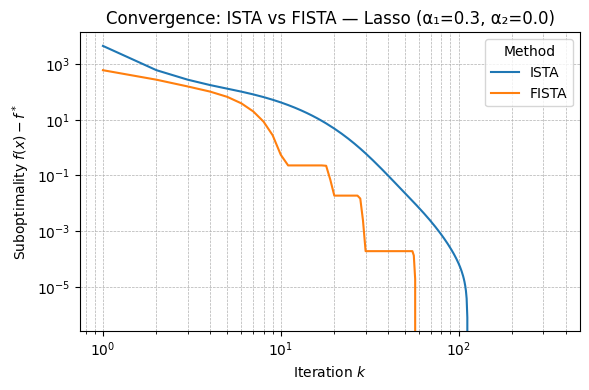

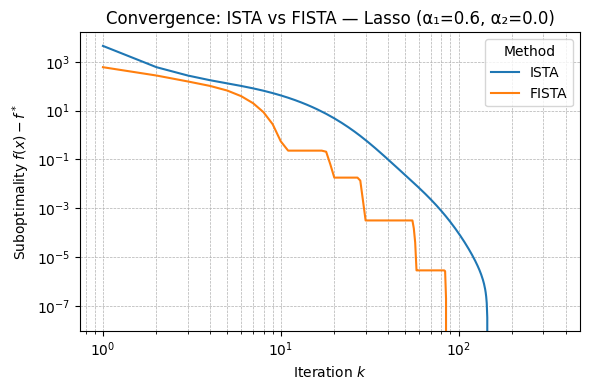

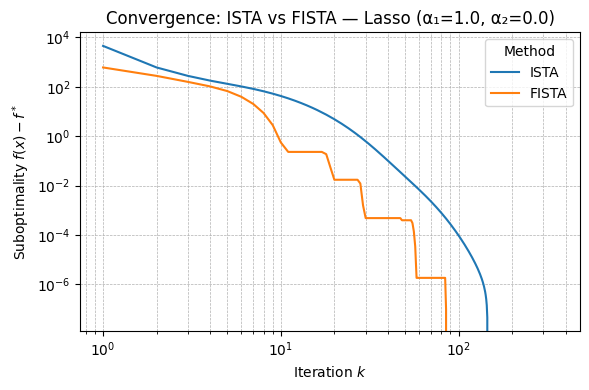

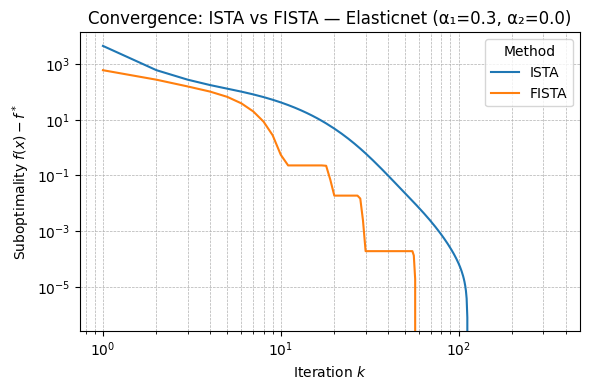

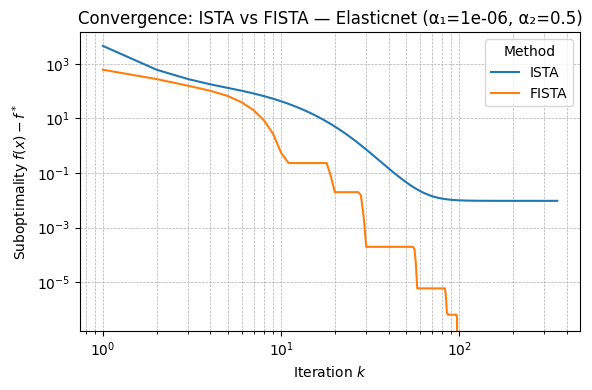

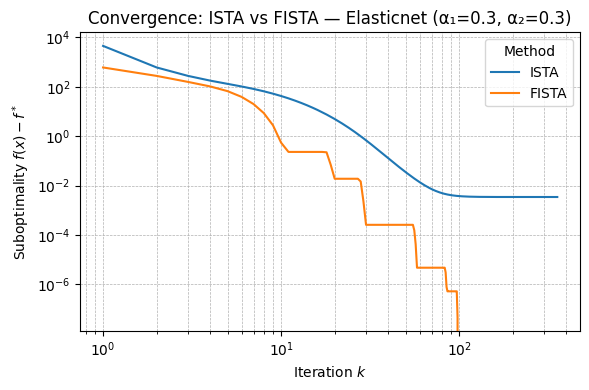

   method regularizer    alpha1  alpha2  iterations  runtime_s
0    ISTA       lasso  0.300000     0.0         359   0.003801
1   FISTA       lasso  0.300000     0.0          78   0.001884
2    ISTA       lasso  0.600000     0.0         359   0.003791
3   FISTA       lasso  0.600000     0.0         120   0.002826
4    ISTA       lasso  1.000000     0.0         359   0.004273
5   FISTA       lasso  1.000000     0.0         120   0.002873
6    ISTA  elasticnet  0.300000     0.0         359   0.004696
7   FISTA  elasticnet  0.300000     0.0          78   0.001935
8    ISTA  elasticnet  0.000001     0.5         354   0.005367
9   FISTA  elasticnet  0.000001     0.5          99   0.002517
10   ISTA  elasticnet  0.300000     0.3         356   0.004432
11  FISTA  elasticnet  0.300000     0.3          99   0.002619


In [103]:
records = []
n, m = A.shape[1], A.shape[0]

for reg in basic_regs:
    # raw settings from scenario
    name_raw = reg['name']      # “lasso”, “ridge” or “elasticnet”
    a1_raw, a2_raw = reg['alpha1'], reg['alpha2']

    # 1) sanitize alphas: tiny values → zero
    a1, a2 = select_effective_alphas(name_raw, a1_raw, a2_raw)

    # 2) define smooth part g, its gradient, and prox operator
    if name_raw == 'lasso':
        def g(x):
            r = A @ x - b
            return 0.5 * r.dot(r)
        def grad_g(x):
            return A.T @ (A @ x - b)
        prox_h = lambda v, t: prox_l1(v, t * a1)
        L0 = estimate_lipschitz(A)
        L  = L0

    elif name_raw == 'elasticnet':
        def g(x):
            r = A @ x - b
            return 0.5 * r.dot(r) + a2 * x.dot(x)
        def grad_g(x):
            return A.T @ (A @ x - b) + 2 * a2 * x
        prox_h = lambda v, t: prox_elastic_net(v, t, a1, a2)
        L0 = estimate_lipschitz(A)
        L  = L0 + 2 * a2

    else:
        # skip pure ridge in this block
        continue

    # 3) run ISTA with history
    x0 = np.zeros(n)
    t0 = time.perf_counter()
    x_i, hist_i = ista(
        x0, g, grad_g, prox_h, L,
        backtracking=False,
        t_init=None,
        max_iter=500,
        tol=TOL,
        return_history=True
    )
    t_ista = time.perf_counter() - t0

    # ensure history was returned
    if hist_i is None or 'x' not in hist_i:
        raise RuntimeError(f"ISTA did not return history for '{name_raw}'")

    # 4) build ISTA objective history
    obj_i = [
        compute_objective(xk, A, b, name_raw, a1, a2)
        for xk in hist_i['x']
    ]

    # 5) run FISTA with history
    t0 = time.perf_counter()
    x_f, hist_f = fista(
        A, b, name_raw, a1, a2,
        max_iter=500,
        tol=TOL,
        return_history=True
    )
    t_fista = time.perf_counter() - t0

    if hist_f is None or 'obj' not in hist_f:
        raise RuntimeError(f"FISTA did not return history for '{name_raw}'")

    obj_f = hist_f['obj']

    # 6) plot convergence envelopes
    f_star = obj_f[-1]
    ks_i   = np.arange(1, len(obj_i) + 1)
    ks_f   = np.arange(1, len(obj_f) + 1)

    plt.figure(figsize=(6, 4))
    plt.loglog(ks_i, np.minimum.accumulate(np.array(obj_i) - f_star), '-', label='ISTA')
    plt.loglog(ks_f, np.minimum.accumulate(np.array(obj_f) - f_star), '-', label='FISTA')
    plt.title(f"Convergence: ISTA vs FISTA — {name_raw.title()} (α₁={a1}, α₂={a2})")
    plt.xlabel('Iteration $k$')
    plt.ylabel('Suboptimality $f(x) - f^*$')
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.legend(title='Method')
    plt.tight_layout()
    plt.show()

    # 7) record summary
    records += [
        {
            'method':      'ISTA',
            'regularizer': name_raw,
            'alpha1':      a1,
            'alpha2':      a2,
            'iterations':  len(obj_i),
            'runtime_s':   t_ista
        },
        {
            'method':      'FISTA',
            'regularizer': name_raw,
            'alpha1':      a1,
            'alpha2':      a2,
            'iterations':  len(obj_f),
            'runtime_s':   t_fista
        }
    ]

# aggregate results
df_basic = pd.DataFrame(records)
print(df_basic)


Ridge Regression via L-BFGS

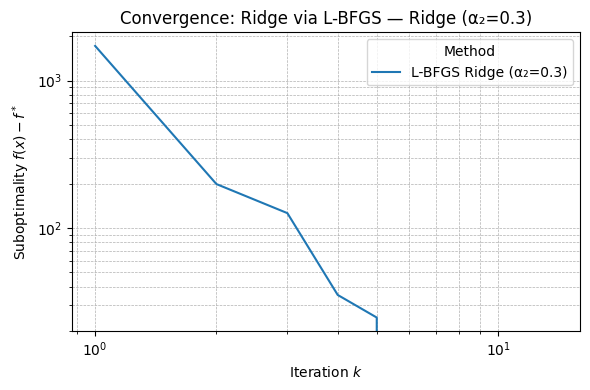

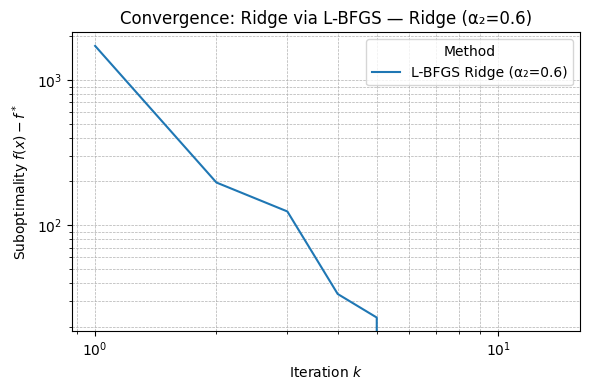

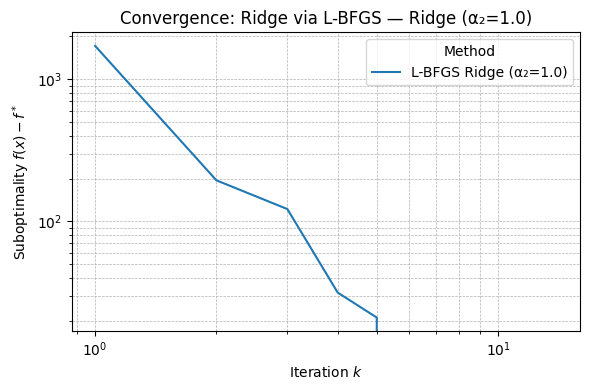

   method regularizer  alpha1  alpha2  iterations  runtime_s
0  L-BFGS       ridge     0.0     0.3          14   0.001925
1  L-BFGS       ridge     0.0     0.6          14   0.000745
2  L-BFGS       ridge     0.0     1.0          14   0.000762


In [104]:
# ── Block 2: Ridge & “≈ Ridge” via L-BFGS ────────────────────────────────
eps = 1e-8
ridge_records = []

for reg in basic_regs:
    # raw settings
    name_raw, a1_raw, a2_raw = reg['name'], reg['alpha1'], reg['alpha2']
    # sanitize α’s
    a1, a2 = select_effective_alphas(name_raw, a1_raw, a2_raw, eps=eps)

    # pick only true Ridge or Elastic-Net ≃ Ridge
    is_ridge_case = (name_raw == 'ridge') or (name_raw == 'elasticnet' and a1_raw < eps)
    if not is_ridge_case:
        continue

    # dynamic label
    if name_raw == 'ridge':
        label = f"Ridge (α₂={a2})"
    else:
        label = f"Elastic-Net ≃ Ridge (α₁≈0, α₂={a2})"

    # configure L-BFGS with the effective alphas
    solver = LBFGSSolver(
        reg_type='ridge',
        alpha1=0.0,   # pure ℓ₂
        alpha2=a2,
        max_iter=500,
        tol=TOL
    )

    # run & time
    t0 = time.perf_counter()
    solver.fit(A, b)
    runtime = time.perf_counter() - t0

    # plot convergence envelope
    ks = np.arange(1, len(solver.history_) + 1)
    plt.figure(figsize=(6, 4))
    plt.loglog(
        ks,
        np.minimum.accumulate(np.array(solver.history_) - solver.final_obj_),
        '-', label=f"L-BFGS {label}"
    )
    plt.title(f"Convergence: Ridge via L-BFGS — {label}")
    plt.xlabel('Iteration $k$')
    plt.ylabel('Suboptimality $f(x)-f^*$')
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.legend(title='Method')
    plt.tight_layout()
    plt.show()

    # record summary
    ridge_records.append({
        'method':      'L-BFGS',
        'regularizer': name_raw,
        'alpha1':      0.0,
        'alpha2':      a2,
        'iterations':  len(solver.history_),
        'runtime_s':   runtime
    })

# assemble into DataFrame
df_ridge = pd.DataFrame(ridge_records)
print(df_ridge)


FISTA vs FISTA-Delta Comparison

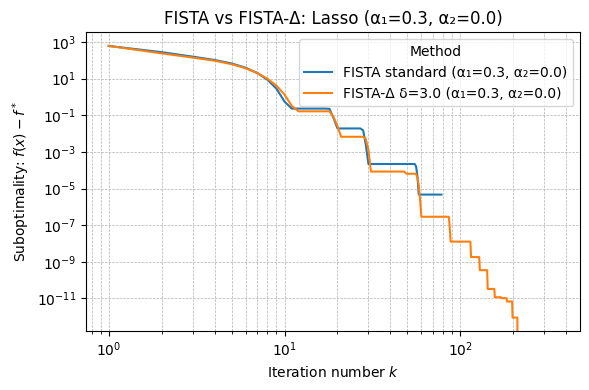

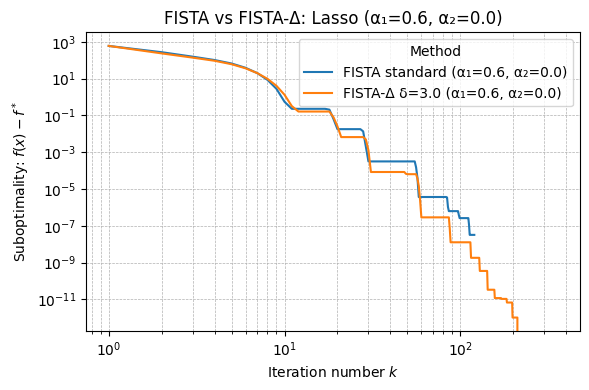

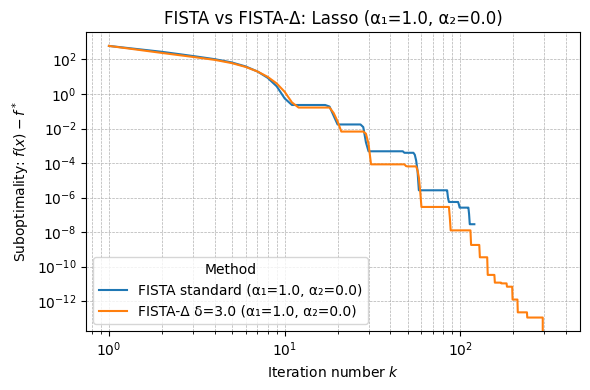

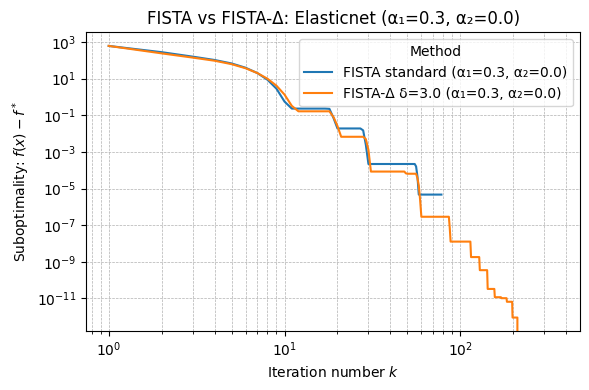

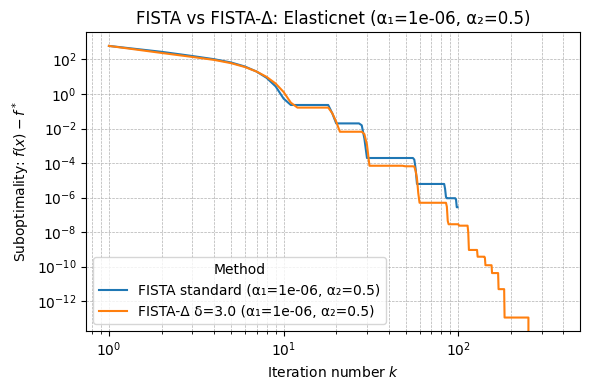

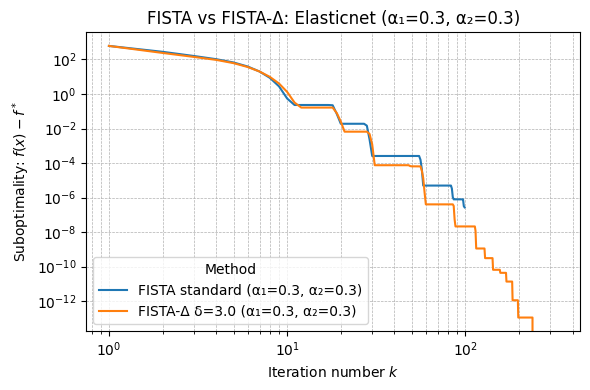

     method  delta regularizer    alpha1  alpha2  iterations  runtime_s
0     FISTA    NaN       lasso  0.300000     0.0          78   0.002853
1   FISTA-Δ    3.0       lasso  0.300000     0.0         357   0.005569
2     FISTA    NaN       lasso  0.600000     0.0         120   0.003321
3   FISTA-Δ    3.0       lasso  0.600000     0.0         357   0.005733
4     FISTA    NaN       lasso  1.000000     0.0         120   0.003187
5   FISTA-Δ    3.0       lasso  1.000000     0.0         357   0.005934
6     FISTA    NaN  elasticnet  0.300000     0.0          78   0.002057
7   FISTA-Δ    3.0  elasticnet  0.300000     0.0         357   0.005933
8     FISTA    NaN  elasticnet  0.000001     0.5          99   0.002543
9   FISTA-Δ    3.0  elasticnet  0.000001     0.5         370   0.006616
10    FISTA    NaN  elasticnet  0.300000     0.3          99   0.002717
11  FISTA-Δ    3.0  elasticnet  0.300000     0.3         329   0.006197


In [105]:
# ── Block 3: FISTA vs FISTA-Δ for Lasso & Elastic-Net ──────────────────
variants = []
delta = 3.0

for reg in basic_regs:
    # raw settings
    name_raw, a1_raw, a2_raw = reg['name'], reg['alpha1'], reg['alpha2']

    # 0) sanitize tiny α’s → 0
    a1, a2 = select_effective_alphas(name_raw, a1_raw, a2_raw)

    # only Lasso or Elastic-Net with nonzero L1
    if name_raw not in ('lasso', 'elasticnet') or a1 <= 0.0:
        continue

    # 1) Standard FISTA (with history)
    t0 = time.perf_counter()
    x_std, hist_std = fista(
        A, b, name_raw, a1, a2,
        max_iter=500,
        tol=TOL,
        return_history=True
    )
    t_std = time.perf_counter() - t0
    obj_std = hist_std['obj']

    # 2) FISTA-Δ variant
    t0 = time.perf_counter()
    x_del, obj_del = fista_delta(
        A, b, name_raw, a1, a2,
        delta=delta,
        max_iter=500,
        tol=TOL
    )
    t_del = time.perf_counter() - t0

    # 3) Build suboptimality envelopes
    f_star = min(obj_std[-1], obj_del[-1])
    ks_std = np.arange(1, len(obj_std) + 1)
    ks_del = np.arange(1, len(obj_del) + 1)
    env_std = np.minimum.accumulate(np.array(obj_std) - f_star)
    env_del = np.minimum.accumulate(np.array(obj_del) - f_star)

    # 4) Plot
    plt.figure(figsize=(6, 4))
    plt.loglog(ks_std, env_std, '-', label=f"FISTA standard (α₁={a1}, α₂={a2})")
    plt.loglog(ks_del, env_del, '-', label=f"FISTA-Δ δ={delta} (α₁={a1}, α₂={a2})")
    plt.title(f"FISTA vs FISTA-Δ: {name_raw.title()} (α₁={a1}, α₂={a2})")
    plt.xlabel('Iteration number $k$')
    plt.ylabel('Suboptimality: $f(x) - f^*$')
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.legend(title='Method')
    plt.tight_layout()
    plt.show()

    # 5) Record results
    variants += [
        {
            'method':      'FISTA',
            'delta':       None,
            'regularizer': name_raw,
            'alpha1':      a1,
            'alpha2':      a2,
            'iterations':  len(obj_std),
            'runtime_s':   t_std
        },
        {
            'method':      'FISTA-Δ',
            'delta':       delta,
            'regularizer': name_raw,
            'alpha1':      a1,
            'alpha2':      a2,
            'iterations':  len(obj_del),
            'runtime_s':   t_del
        }
    ]

# 6) Aggregate into DataFrame
df_variants = pd.DataFrame(variants)
print(df_variants)
